In [1]:
import pandas as pd
import os
import librosa
import librosa.display
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 


In [2]:
data_path = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_train/sample'
labels_path = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'



In [3]:
def extract_cqt(filename):
    try:
        y, sr = librosa.load(data_path + '/' + filename)
        #cqt = np.abs(librosa.cqt(y, sr=sr))
        cqt = np.abs(librosa.cqt(y, sr=sr, fmin=librosa.note_to_hz('C2'),
                n_bins=60 * 2, bins_per_octave=12 * 2))
    except Exception as e:
        print("Error encountered while parsing file: ", filename)
        return None 
     
    return cqt,sr
    
    

In [4]:
filename2label = {}
for line in open(labels_path):
    line = line.split()
    filename, label = line[1], line[-1]
    filename2label[filename] = label

In [7]:
def get_mel_spectrogram(filename):
    #do processing on a single file based on it name
    try:
        y, sr = librosa.load(data_path + '/' + filename)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
    except Exception as e:
        print("Error encountered while parsing file: ", filename)
        return None 
     
    return S,sr

In [8]:
def get_fft_spectrogram(filename):
    #do processing on a single file based on it name
    try:
        y, sr = librosa.load(data_path + '/' + filename)
        fft = np.abs(librosa.stft(y=y, sr=sr))
    except Exception as e:
        print("Error encountered while parsing file: ", filename)
        return None 
     
    return fft,sr

In [9]:
def extract_n_features(x):
    #t_start = time.time() 
   
    feats = []
    for filename in x:
        if filename.split('.')[0] in filename2label:
            class_label = filename2label[filename.split('.')[0]]
            
            data_list = []
            spec,sr = get_mel_spectrogram(filename)
            cqt,sr = extract_cqt(filename)

            data_list.append(spec)
            data_list.append(cqt)

            data_clean = []
            for data in data_list:
                if(target_num_rows > data.shape[1]):
                    # repeat sample
                    while(target_num_rows != data.shape[1]):
                        data = np.concatenate((data, data[:,:target_num_rows - data.shape[1]]), axis=1)
                else:
                    #cut  sample
                    data = data[:,:target_num_rows] 
                data_clean.append(data)
            
            col_size = min(data_list[0].shape[0],data_list[1].shape[0])
            feats.append([data_clean[0][:col_size,:],data_clean[1][:col_size,:], class_label,filename])
        
    return feats

In [10]:
features = []
target_num_rows = 150
total_file = len(os.listdir(data_path))
counter = 1
# Iterate through each sound file and extract the features 
for filename in os.listdir(data_path):
    class_label = filename2label[filename.split('.')[0]]
    data_list = []
    spec,sr = get_mel_spectrogram(filename)
    cqt,sr = extract_cqt(filename)
    
    data_list.append(spec)
    data_list.append(cqt)
    
    data_clean = []
    
    for data in data_list:
        if(target_num_rows > data.shape[1]):
        # repeat sample untill size reached
            while(target_num_rows != data.shape[1]):
                data = np.concatenate((data, data[:,:target_num_rows - data.shape[1]]), axis=1)
        else:
        #cut  sample
            data = data[:,:target_num_rows] 
        
        data_clean.append(data)
        
    
    col_size = min(data_list[0].shape[0],data_list[1].shape[0])
    
        
    
    # cut data to specified targetnum of rows
#     if(target_num_rows > data.shape[1]):
#         # repeat sample
#         while(target_num_rows != data.shape[1]):
#             data = np.concatenate((data, data[:,:target_num_rows - data.shape[1]]), axis=1)
#     else:
#         #cut  sample
#         data = data[:,:target_num_rows] 

    
    features.append([data_clean[0][:col_size,:],data_clean[1][:col_size,:], class_label,filename])
    if 100%counter == 0:
        print( ((counter/total_file)*100), '% done' )
    
    counter=counter+1
    print(counter, 'out of ', total_file, 'done')

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature1','feature2','class_label','filename'])

print('Finished feature extraction from ', len(featuresdf), ' files')

16.666666666666664 % done
2 out of  6 done
33.33333333333333 % done
3 out of  6 done
4 out of  6 done
66.66666666666666 % done
5 out of  6 done
83.33333333333334 % done
6 out of  6 done
7 out of  6 done
Finished feature extraction from  6  files


In [10]:
# filename2label['LA_D_A6141181']

if 'LA_D_A6141181' in filename2label:
    print('LA_D_A6141181')

In [16]:
featuresdf.sample(1)['feature1'].values[0].shape

(120, 150)

/Users/asimadnan/opt/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/asimadnan/opt/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


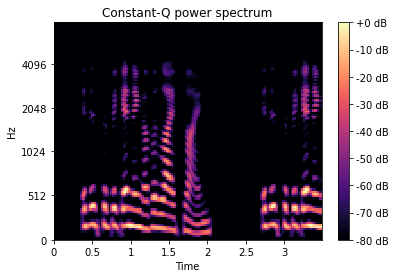

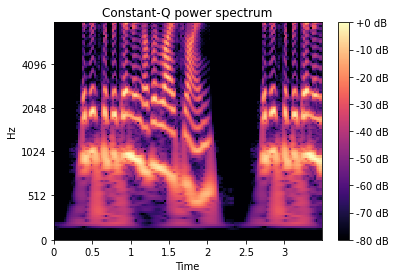

In [11]:
################################
#ploting a random sample
#########################

fig, ax = plt.subplots()
# img = librosa.display.specshow(librosa.amplitude_to_db(featuresdf.sample(1)['feature'].values[0], ref=np.max),
#                                sr=22050, x_axis='time', y_axis='cqt_note', ax=ax)
img = librosa.display.specshow(librosa.amplitude_to_db(featuresdf.sample(1)['feature1'].values[0], ref=np.max), x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

fig, ax = plt.subplots()
# img = librosa.display.specshow(librosa.amplitude_to_db(featuresdf.sample(1)['feature'].values[0], ref=np.max),
#                                sr=22050, x_axis='time', y_axis='cqt_note', ax=ax)
img = librosa.display.specshow(librosa.amplitude_to_db(featuresdf.sample(1)['feature2'].values[0], ref=np.max), x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

# Make 2 chanel data

In [79]:
X_1 = np.array(featuresdf.feature1.tolist())
X_2 = np.array(featuresdf.feature2.tolist())
y = np.array(featuresdf.class_label.tolist())
filenames = np.array(featuresdf.filename.tolist())

In [80]:
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 
yy = yy[:,0]


In [81]:
print( X_1[0].shape)
print( X_2[0].shape)

(120, 150)
(120, 150)


In [85]:
x_train = []
for i,u in enumerate(X_1):
    x_train.append(np.dstack((X_1[i], X_2[i])))

x_train = np.asarray(x_train)
print(x_train.shape)

(6, 120, 150, 2)


In [86]:
num_rows = x_train.shape[1]
num_columns = x_train.shape[2]
num_channels =  x_train.shape[3]
filter_size = 2

# Normal 1 chanell code

In [12]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
filenames = np.array(featuresdf.filename.tolist())

# np.save('X-cqt-sample', X)
# np.save('y-cqt-sample', y)
# np.save('filenames-cqt-sample', filenames)
# X = np.load('X-cqt.npy')


In [10]:

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 
yy = yy[:,0]

# split the dataset 
# x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [15]:
num_rows = X[0].shape[0]
num_columns = X[0].shape[1]
num_channels = 1
filter_size = 2

In [16]:
x_train = []
for u in X:
    x_train.append(np.reshape(u, (num_rows, num_columns, num_channels)))
x_train = np.asarray(x_train)

In [16]:
# x_train_2 = []
# x_test_2 = []
# for u in x_train:
#     x_train_2.append(np.reshape(u, (num_rows, num_columns, num_channels)))

    
# for u in x_test:
#     x_test_2.append(np.reshape(u, (num_rows, num_columns, num_channels)))
    
# x_train = np.asarray(x_train_2)
# x_test = np.asarray(x_test_2)


# CNN

In [87]:
activation_func = 'relu'

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation=activation_func, input_shape=(num_rows, num_columns, num_channels)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation=activation_func, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation=activation_func, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation=activation_func, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation=activation_func, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation=activation_func),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation=activation_func),
    keras.layers.Dropout(0.5),
    #keras.layers.Dense(2, activation='softmax')
    keras.layers.Dense(1, activation='sigmoid')
])

In [27]:
# root_logdir = os.path.join(os.curdir, "logs/fit")
# def get_run_logdir():
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir, run_id)
# run_logdir = get_run_logdir()
# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [88]:
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.SGD(lr=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 35, 96)        23328     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 35, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 17, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 384)         8

In [89]:
model.fit(x_train,yy,epochs=5)
#           validation_data=(x_test, y_test),
#           validation_freq=1
#          )

# ,
#           callbacks=[tensorboard_cb]

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 1.8803 - accuracy: 0.3333
Epoch 2/5
1/1 [==============================] - 0s 425ms/step - loss: 1.5949 - accuracy: 0.6667
Epoch 3/5
1/1 [==============================] - 0s 442ms/step - loss: 0.8750 - accuracy: 0.6667
Epoch 4/5
1/1 [==============================] - 1s 590ms/step - loss: 0.8959 - accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 0s 430ms/step - loss: 1.2799 - accuracy: 0.5000


In [161]:
model.save('cqt-sample')

INFO:tensorflow:Assets written to: cqt-sample/assets


In [ ]:
# loading mode etc

In [3]:
model = tf.keras.models.load_model('cqt-alexnet-50-22-epoch')
X = np.load('X-cqt-sample.npy')
y = np.load('y-cqt-sample.npy')
filenames = np.load('filenames-cqt-sample.npy')
dev_protocol = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'


In [4]:
x_dev = []
for u in X:
    x_dev.append(np.reshape(u, (num_rows, num_columns, num_channels)))
x_dev = np.asarray(x_dev)

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 


NameError: name 'num_rows' is not defined

In [192]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 35, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 35, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 17, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 384)         8

In [193]:
results = model.predict(x_dev)

In [194]:
results

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

In [166]:
results[:,0]

array([0.476032  , 0.4873293 , 0.47213998, 0.42264065, 0.4734487 ,
       0.4760521 ], dtype=float32)

In [123]:
filenames_temp = []
for f in filenames:
    filenames_temp.append(f.split('.')[0])
filenames = np.asarray(filenames_temp)

In [124]:
filenames

array(['LA_T_2361751', 'LA_T_1703395', 'LA_T_1276960', 'LA_T_9411527',
       'LA_T_4795888', 'LA_T_4578643'], dtype='<U12')

In [125]:
scores = pd.DataFrame({'SCORE': results[:,0], 'AUDIO_FILE_NAME': filenames})
scores

,SCORE,AUDIO_FILE_NAME
0,0.506615,LA_T_2361751
1,0.503141,LA_T_1703395
2,0.511476,LA_T_1276960
3,0.503411,LA_T_9411527
4,0.502129,LA_T_4795888
5,0.500439,LA_T_4578643


In [127]:
labels = pd.read_csv(dev_protocol, delimiter = " ", header=None)
labels.columns = ['SPEAKER_ID','AUDIO_FILE_NAME','ENVIRONMENT_ID','ATTACK_ID','KEY']


In [129]:
pd.merge(scores, labels, on='AUDIO_FILE_NAME')[['AUDIO_FILE_NAME','ATTACK_ID','KEY','SCORE']].to_csv(os.path.join(output_path + 'gmm_dev_scores.csv'),index=False,sep=" ",header=False)

,AUDIO_FILE_NAME,ATTACK_ID,KEY,SCORE
0,LA_T_2361751,-,bonafide,0.506615
1,LA_T_1703395,-,bonafide,0.503141
2,LA_T_1276960,-,bonafide,0.511476
3,LA_T_9411527,A03,spoof,0.503411
4,LA_T_4795888,A03,spoof,0.502129
5,LA_T_4578643,A03,spoof,0.500439


In [ ]:
labels[['AUDIO_FILE_NAME','ATTACK_ID','KEY','SCORE']].to_csv(os.path.join(output_path + 'gmm_dev_scores.csv'),index=False,sep=" ",header=False)
